In [11]:
import numpy as np
from typing import List 
from scipy import stats
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [12]:
class Bandit:
    def __init__(self, rvs: callable):
        self.rvs = rvs 
        self.p_estimate = 0.0
        self.N = 0

    def pull(self):
        return self.rvs()

    def update(self, x):
        self.N += 1
        self.p_estimate = self.p_estimate + (x - self.p_estimate) / self.N

In [13]:
def ucb(mean, n, nj):
    return mean + np.sqrt(2 * np.log(n) / nj)

In [14]:
# Epsilon functions
def linear_decay(eps, N):
    return eps / N

def setup_alpha_decay(alpha=0.2):
    def alpha_decay(eps, N):
        return eps * alpha**N
    return alpha_decay 

def setup_max_decay(k, eps_0=1.0, eps_min=0.01):
    def max_decay(eps, N):
        return max(eps_0 - k * N, eps_min)
    return max_decay 

def setup_log_decay(a, b):
    def log_decay(eps, N):
        return a / np.log(b * N + eps)
    return log_decay

In [15]:
# Random Variables 
def setup_normal(mu: float = 0.0, sd: float = 1.0) -> callable:
    def normal_rvs():
        return np.random.normal(mu, sd) 
    return normal_rvs

def setup_exponential(m: float, mu: float = 1.0, sd: float = 1.0) -> callable:
    def exp_rvs():
        return stats.expon(loc=mu, scale=sd) + m
    return exp_rvs 

In [16]:
def experiment(eps: float = 0.1, num_trials: int = 10000, bandit_skews: List[float] = [0.01, 0.2, 0.7], decay: float or None = None, show_plots: bool = False):
    bandits = [Bandit(setup_normal(mu=skew)) for skew in bandit_skews]
    n_bandits = len(bandits)
    rewards = np.zeros(num_trials)
    num_times_explored = 0
    num_times_exploited = 0
    num_optimal = 0
    optimal_j = np.argmax(bandit_skews)
    print(f'Optimal bandit: {optimal_j}')

    # Initialization step: play each bandit once
    for bandit in bandits:
        x = bandit.pull()
        bandit.update(x)

    for i in range(num_trials):
        # Use greedy mehtod to select the next bandit
        num_times_exploited += 1
        # Calculate the Upper Confidence Bounds for each bandit 
        ucbs = [ucb(bandit.p_estimate, i + 1, bandit.N) for bandit in bandits]
        j = np.argmax(ucbs)
        if j == optimal_j:
            num_optimal += 1
        # Pull the arm for the bandit choosen
        x = bandits[j].pull()
        # Update the rewards log
        rewards[i] = x
        # Update the distribution for the chosen bandit
        bandits[j].update(x)
        # Decay the eps 
        if decay:
            eps = decay(eps, i + 1)

    # Print the mean estimates for each bandit
    for i, bandit in enumerate(bandits):
        print(f'Mean estimate of bandit {i}: {bandit.p_estimate:.4f}')
    
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(num_trials) + 1)

    if show_plots:
        # Print total reward
        print(f"Total reward earned: {rewards.sum()}")
        print(f"Overall win rate: {rewards.sum() / num_trials}")
        print(f"Num_times_explored: {num_times_explored}")
        print(f"Num_times_exploited: {num_times_exploited}")
        print(f"Num times selected optimal bandit: {num_optimal}")
    
        # plot the results
        plt.figure(figsize=(15, 8))
        plt.plot(win_rates)
        for skew in bandit_skews:
            plt.plot(np.ones(num_trials) * skew)
        plt.plot(np.ones(num_trials) * np.max(bandit_skews))
        plt.xscale('log')
        plt.show()
    return win_rates

Optimal bandit: 2
Mean estimate of bandit 0: 0.1332
Mean estimate of bandit 1: 0.0671
Mean estimate of bandit 2: 0.6964
Optimal bandit: 2
Mean estimate of bandit 0: -0.1595
Mean estimate of bandit 1: 0.0604
Mean estimate of bandit 2: 0.6890
Optimal bandit: 2
Mean estimate of bandit 0: 0.0198
Mean estimate of bandit 1: 0.2907
Mean estimate of bandit 2: 0.7040


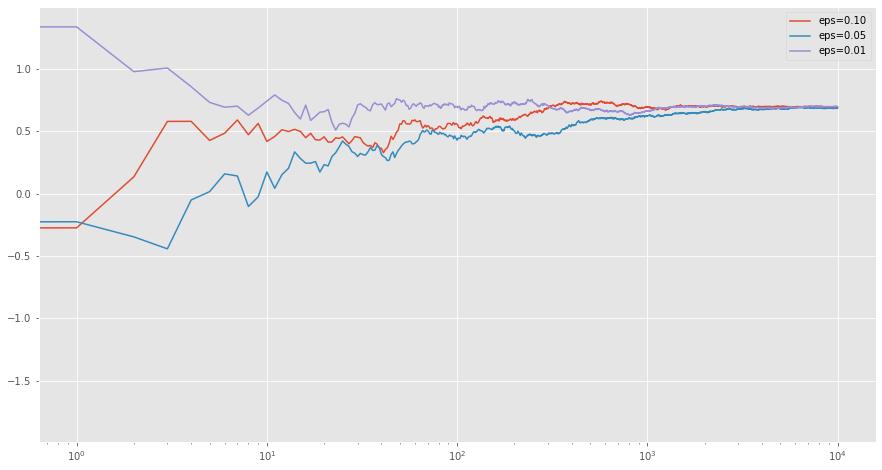

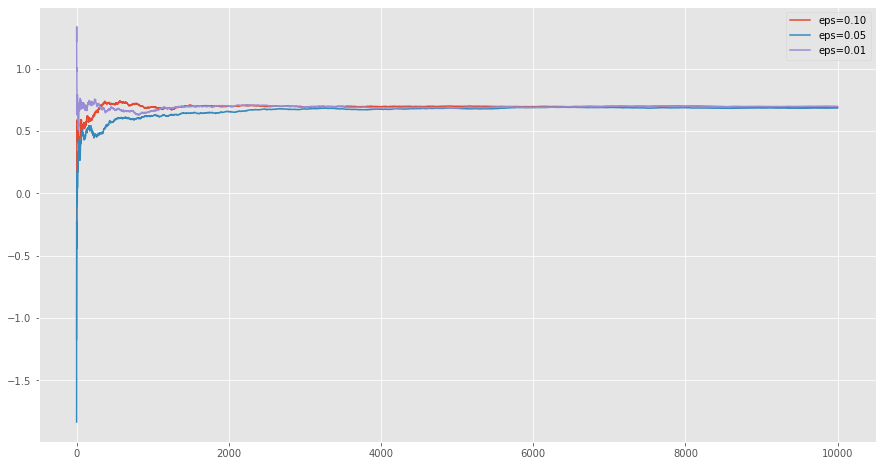

In [17]:
c_10 = experiment(eps=0.1)
c_05 = experiment(eps=0.05)
c_01 = experiment(eps=0.01)

plt.figure(figsize=(15, 8))
plt.plot(c_10, label="eps=0.10")
plt.plot(c_05, label="eps=0.05")
plt.plot(c_01, label="eps=0.01")
plt.legend()
plt.xscale('log')
plt.show() 


plt.figure(figsize=(15, 8))
plt.plot(c_10, label="eps=0.10")
plt.plot(c_05, label="eps=0.05")
plt.plot(c_01, label="eps=0.01")
plt.legend()
plt.show() 


Optimal bandit: 2
Mean estimate of bandit 0: 0.5728
Mean estimate of bandit 1: 0.6074
Mean estimate of bandit 2: 0.6971
Total reward earned: 6953.789752707504
Overall win rate: 0.6953789752707504
Num_times_explored: 0
Num_times_exploited: 10000
Num times selected optimal bandit: 9958


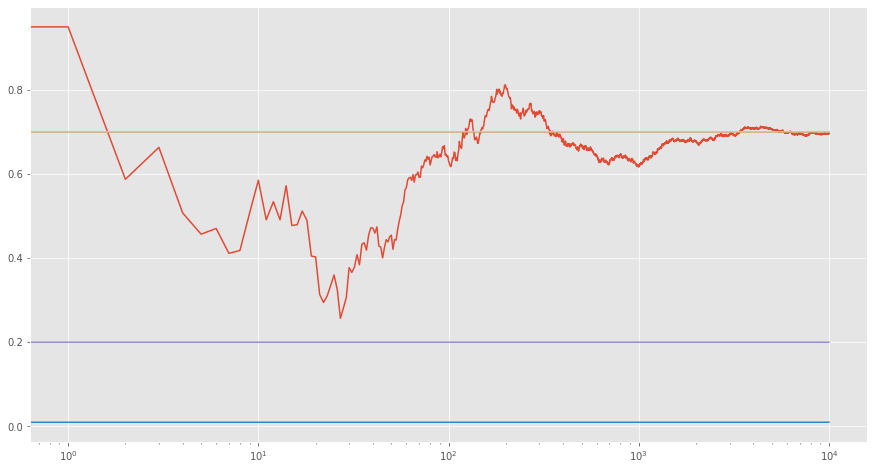

array([0.85940384, 0.94906579, 0.58709703, ..., 0.69534008, 0.69526955,
       0.69537898])

In [ ]:
experiment(eps=10.0, decay=linear_decay, show_plots=True)

Optimal bandit: 2
Mean estimate of bandit 0: 0.3792
Mean estimate of bandit 1: 0.6206
Mean estimate of bandit 2: 0.7055
Total reward earned: 7036.977005154999
Overall win rate: 0.7036977005154998
Num_times_explored: 0
Num_times_exploited: 10000
Num times selected optimal bandit: 9969


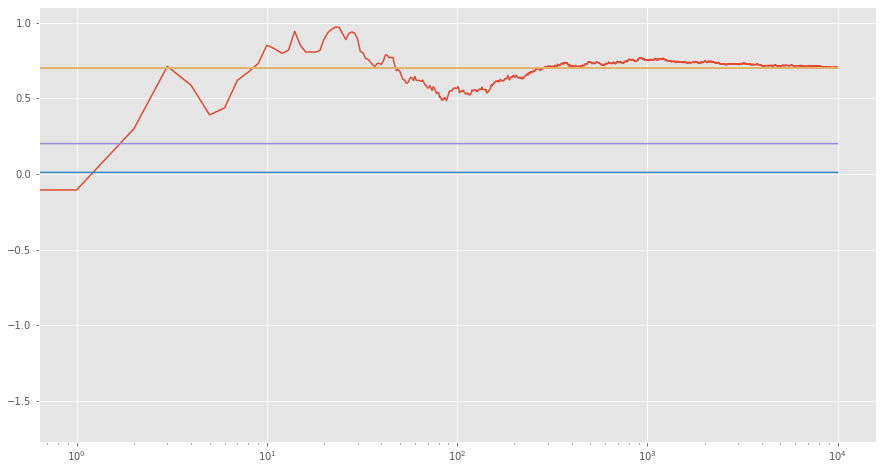

array([-1.64059895, -0.10599257,  0.29812178, ...,  0.70377037,
        0.70365624,  0.7036977 ])

In [ ]:
experiment(eps=0.75, decay=setup_alpha_decay(0.99), show_plots=True)

Optimal bandit: 2
Mean estimate of bandit 0: 0.6344
Mean estimate of bandit 1: 0.5854
Mean estimate of bandit 2: 0.7078
Total reward earned: 7062.492197994315
Overall win rate: 0.7062492197994314
Num_times_explored: 0
Num_times_exploited: 10000
Num times selected optimal bandit: 9978


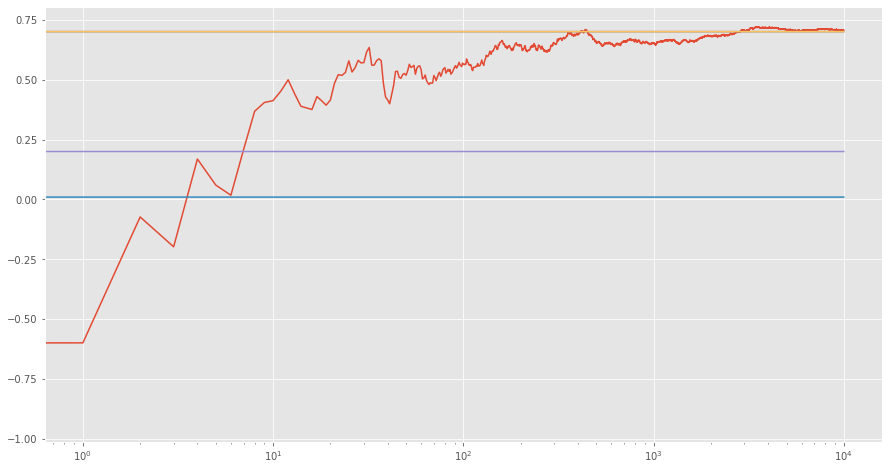

array([-0.92888565, -0.59793862, -0.07286919, ...,  0.70638255,
        0.70635644,  0.70624922])

In [ ]:
experiment(eps=0.75, decay=setup_max_decay(0.9), show_plots=True)

Optimal bandit: 2
Mean estimate of bandit 0: 0.4263
Mean estimate of bandit 1: 0.4184
Mean estimate of bandit 2: 0.6946
Total reward earned: 6924.523285924278
Overall win rate: 0.6924523285924278
Num_times_explored: 0
Num_times_exploited: 10000
Num times selected optimal bandit: 9971


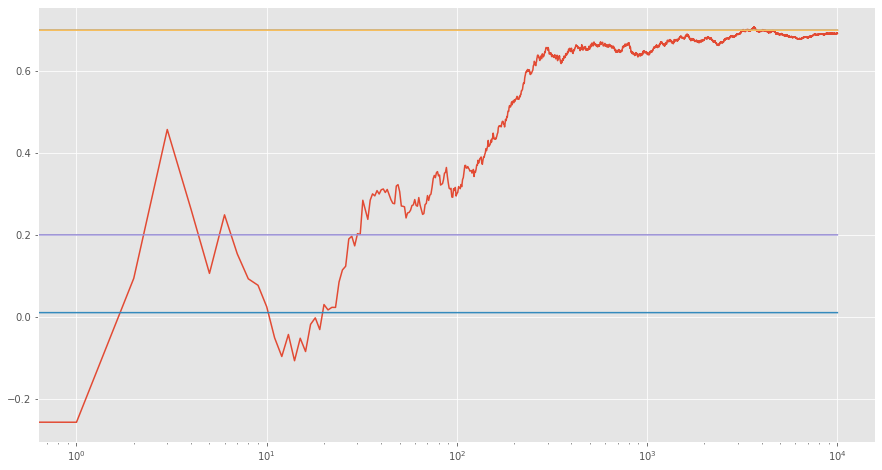

array([ 0.21064707, -0.25778747,  0.09380046, ...,  0.69243454,
        0.69246572,  0.69245233])

In [ ]:
experiment(0.01, show_plots=True)